In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from sklearn.utils import resample
import ray
from ray import tune
from ray.tune.examples.mnist_pytorch import get_data_loaders, ConvNet, train, test
from ray.tune import CLIReporter
%matplotlib inline

ray.shutdown()
ray.init()

2021-03-04 13:59:49,532	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.1.34',
 'raylet_ip_address': '192.168.1.34',
 'redis_address': '192.168.1.34:6379',
 'object_store_address': 'tcp://127.0.0.1:65458',
 'raylet_socket_name': 'tcp://127.0.0.1:65444',
 'webui_url': '127.0.0.1:8265',
 'session_dir': 'C:\\Users\\Pierre\\AppData\\Local\\Temp\\ray\\session_2021-03-04_13-59-49_151186_9108',
 'metrics_export_port': 65501,
 'node_id': 'd9ddbd9df73d2dffea0bd7b4d2111c7578d2cf15a01390807a2d2401'}

In [2]:
filename = "./data/wine.csv"
df = pd.read_csv(filename)
# drop col index
df = df.drop(['index'],axis = 1)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
#Resample:
df_majority = df[df['quality']== 6]
for i in range(3,10):
    majority_len = df[df['quality']== 6].shape[0]
    if i != 6:
        minority_len = df[df['quality'] == i].shape[0]

        df_minority = df[df['quality'] == i]

        df_majority_upsampled = resample(df_minority,replace=True,n_samples = majority_len,random_state=1)

        df_majority = df_majority.append(df_majority_upsampled)
        

df = df_majority
print(df.shape)
print(df['quality'].value_counts())
df = df.sample(frac=1).reset_index(drop=True) # Shuffle dataframe

(19852, 12)
3    2836
4    2836
5    2836
6    2836
7    2836
8    2836
9    2836
Name: quality, dtype: int64


In [4]:
# Creating a test/train split

train_test_split_fraction = 0.80
split_index = int(df.shape[0] * train_test_split_fraction)
df_train = df[:split_index]
df_test = df[split_index:]

target = pd.get_dummies(df['quality']).values # One hot encode

#target[:5]
#target = df['quality'].to_numpy()
#target = target.reshape(6497,1)

target

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=uint8)

In [5]:
# Selecting the features and the target
X_train = df_train.drop('quality', axis = 1).values
X_test = df_test.drop('quality', axis = 1).values

y_train = target[:split_index]
y_test = target[split_index:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15881, 11)
(3971, 11)
(15881, 7)
(3971, 7)


In [7]:
X_train = torch.tensor(X_train.astype(np.float32)) 
y_train = torch.tensor(y_train.astype(np.float32))
X_test = torch.tensor(X_test.astype(np.float32)) 
y_test = torch.tensor(y_test.astype(np.float32))

AttributeError: 'Tensor' object has no attribute 'astype'

In [8]:
# NEED TO DEFINE NEURONS,BATCH,EPOCHS,NB_LAYER,MODEL,LOSS FUNC
#nb_hidden_neurons = 100
nb_layer = 4 
nb_features=X_train.shape[1]
nb_classes = len(pd.unique(df['quality']))
#activation_function = nn.SiLU()
#last_layer_activation = nn.Softmax()
layer_kind = nn.Linear
#batch_size = 50
#epochs = 75
#criterion = nn.MSELoss()
#learning_rate = 0.001

In [12]:
class Network(nn.Module):

    def __init__(self,nb_features,nb_classes,nb_layer,activation_function,last_layer_activation,layer_kind,nb_hidden_neurons):
        """Here we define the layers
        """
        
        super().__init__()
        self.activation_function = activation_function
        self.last_layer_activation = last_layer_activation
       
        for i in range(1,nb_layer):
            if i == 1 :
                setattr(self, f"layer_{i}", layer_kind(nb_features,nb_hidden_neurons))
            elif i == nb_layer-1:
                setattr(self, f"layer_{i}", layer_kind(nb_hidden_neurons,nb_classes))
            else:
                setattr(self, f"layer_{i}", layer_kind(nb_hidden_neurons,nb_hidden_neurons))
            
        
        

    def forward(self,x):
        """Here we combine the layers
        """
        for i in range(1,nb_layer):
            if i == nb_layer-1:
                x = self.last_layer_activation(getattr(self,f'layer_{i}')(x))
            else:
                x = self.activation_function(getattr(self,f'layer_{i}')(x))
                
        return x

In [9]:
#my_nn = Network(nb_features,nb_classes,nb_layer,activation_function,last_layer_activation,layer_kind)
#my_nn
#optimizer = torch.optim.Adam(my_nn.parameters(), lr=learning_rate)

In [9]:
def training(config):
    """ Train the neural network, feeding it `batch_size` at a time
    and saving statistics every `nb_steps_loss_sum` steps.
    
    Arguments:
    
    - batch_size [int] : the number of input samples at each training step (called a batch)
    - nb_steps_loss_sum [int] : the number of batches before saving the loss for plotting
    
    Returns:
    - loss_list : [List[double]] : value of the loss every `nb_steps_loss_sum` steps
    """

    nb_steps_loss_sum = 10 
    #optimizer = config["optimizer"]
    batch_size = config["batch_size"]
    epochs = config["epoch"]
    nb_layer = 4 
    activation_function=config["activation_function"]
    last_layer_activation=config["last_layer_activation"]
    nb_hidden_neurons=config["nb_hidden_neurons"]
   
    my_nn = Network(nb_features,nb_classes,
                    nb_layer,
                    activation_function,
                    last_layer_activation,
                    layer_kind,
                    nb_hidden_neurons)
    my_nn
     
    optimizer = torch.optim.AdamW(my_nn.parameters(), lr=config["lr"])
    loss_list = []
    running_loss = 0
    batch_nb = 0
    history = []

    for epoch in range(epochs): # Number of times to iterate through the complete dataset
        for idx in range(0, X_train.shape[0], batch_size):
            
            # Get input and output
            input_batch = X_train[idx:idx + batch_size]
            target = y_train[idx:idx + batch_size]
            
            # TO COMPLETE:
            # - zero gradient buffers
            optimizer.zero_grad()
            # - compute the forward pass
            output = my_nn(input_batch.float())
            # - compute the loss
            loss = config["criterion"](output, target.float())
            # - backpropagate
            loss.backward()
            # - do a step
            optimizer.step()
          
            
            # Save the loss every `running_loss_steps` batches
            running_loss += loss.item()
            save_loss_condition = batch_nb % nb_steps_loss_sum == (nb_steps_loss_sum - 1)
            if save_loss_condition:    
                loss_list.append(running_loss)
                running_loss = 0.0


            batch_nb+= 1
        
        tune.report(loss=abs(loss_list[len(loss_list)-1]))

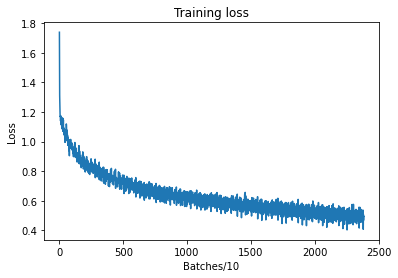

In [11]:
nb_steps_loss_sum = 10
loss = training(batch_size=batch_size, nb_steps_loss_sum=nb_steps_loss_sum,epochs=epochs)

# Plotting the loss over training
plt.figure()
plt.plot(range(0, len(loss)), loss)
plt.xlabel(f"Batches/{nb_steps_loss_sum}")
plt.ylabel("Loss")
plt.title("Training loss")
plt.show()
plt.close()

In [10]:
def computeScore(X, y,batch_size):

    correct = 0
    total = 0
    with torch.no_grad():
        for idx in range(0, X.shape[0], batch_size):
            
            output = my_nn(X.float())
            max_pred = torch.max(output, 1)
            max_target = torch.max(y, 1)
            if max_pred[1][idx] == max_target[1][idx]:
                correct += 1
            total = total + 1

    accuracy = correct/total * 100
    print(f"Accuracy of the network on the {total} samples: {accuracy:.2f}%")

In [13]:
computeScore(X_train, y_train,batch_size)
computeScore(X_test, y_test,batch_size)

Accuracy of the network on the 318 samples: 77.99%
Accuracy of the network on the 80 samples: 63.75%


In [23]:
#import torch.optim as optim


#def train_mnist(config):
    
 #   model = Network(nb_features=X_train.shape[1])
  #  optimizer = optim.SGD(model.parameters(), lr=config["lr"])
   # for i in range(10):
    #    training(batch_size=50, nb_steps_loss_sum=nb_steps_loss_sum)
     #   acc = computeScore(X_train, y_train)
      #  tune.report(mean_accuracy=acc)






[I 2021-03-03 16:01:32,597] A new study created in memory with name: no-name-5dc963a4-dd7e-4a1d-90e9-7b6721e85abc
[W 2021-03-03 16:01:32,600] Trial 0 failed because of the following error: NameError("name 'accuracy' is not defined")
Traceback (most recent call last):
  File "C:\Users\Pierre\anaconda3\envs\pytorch\lib\site-packages\optuna\_optimize.py", line 211, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-21-2d4844b43f13>", line 13, in objective
    return accuracy
NameError: name 'accuracy' is not defined


NameError: name 'accuracy' is not defined

In [13]:
from ray.tune.schedulers import ASHAScheduler

scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        reduction_factor=2,
        max_t=5,
        grace_period=5,
        brackets=3)


search_space = {
    "lr": tune.grid_search([0.01,0.001]),
    #"momentum": tune.uniform(0.1, 0.9),
    "batch_size": tune.grid_search([50]),
    #"optimizer": tune.grid_search(['Adam']),
    "epoch": tune.grid_search([40,50]),
    "nb_hidden_neurons": tune.grid_search([10,20]),
    "activation_function": tune.grid_search([nn.SiLU()]),
    "last_layer_activation": tune.grid_search([nn.Softmax()]),
    "criterion": tune.grid_search([nn.MSELoss()]),
}

analysis = tune.run(training, config=search_space,scheduler=scheduler)
print("Best config: ", analysis.get_best_config(metric="loss",mode="min"))

# Get a dataframe for analyzing trial results.
test = analysis.dataframe()

Trial name,status,loc,activation_function,batch_size,criterion,epoch,last_layer_activation,lr,nb_hidden_neurons
training_a29bf_00000,RUNNING,,SiLU(),50,MSELoss(),40,Softmax(dim=None),0.01,10


Result for training_a29bf_00001:
  date: 2021-03-04_14-00-47
  done: false
  experiment_id: c68a37fd34a54dcfa9ecf1f4f12896ad
  hostname: DESKTOP-7AOOQS1
  iterations_since_restore: 1
  loss: 1.1286730915307999
  node_ip: 192.168.1.34
  pid: 20720
  time_since_restore: 0.45407843589782715
  time_this_iter_s: 0.45407843589782715
  time_total_s: 0.45407843589782715
  timestamp: 1614862847
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a29bf_00001
  
Result for training_a29bf_00000:
  date: 2021-03-04_14-00-48
  done: false
  experiment_id: d90f3d7c7483439987eaf0f9e8f5fea1
  hostname: DESKTOP-7AOOQS1
  iterations_since_restore: 1
  loss: 1.1448395252227783
  node_ip: 192.168.1.34
  pid: 13716
  time_since_restore: 0.4775841236114502
  time_this_iter_s: 0.4775841236114502
  time_total_s: 0.4775841236114502
  timestamp: 1614862848
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a29bf_00000
  
Result for training_a29bf_00002:
  date: 2021-03-04_14-00-48
  do

Trial name,status,loc,activation_function,batch_size,criterion,epoch,last_layer_activation,lr,nb_hidden_neurons,iter,total time (s),loss
training_a29bf_00000,TERMINATED,,SiLU(),50,MSELoss(),40,Softmax(dim=None),0.01,10,5,1.75981,0.902913
training_a29bf_00001,TERMINATED,,SiLU(),50,MSELoss(),50,Softmax(dim=None),0.01,10,5,1.7183,0.932676
training_a29bf_00002,TERMINATED,,SiLU(),50,MSELoss(),40,Softmax(dim=None),0.001,10,5,1.6973,1.028
training_a29bf_00003,TERMINATED,,SiLU(),50,MSELoss(),50,Softmax(dim=None),0.001,10,5,1.7583,1.09159
training_a29bf_00004,TERMINATED,,SiLU(),50,MSELoss(),40,Softmax(dim=None),0.01,20,5,1.78531,0.799239
training_a29bf_00005,TERMINATED,,SiLU(),50,MSELoss(),50,Softmax(dim=None),0.01,20,5,1.78681,0.821667
training_a29bf_00006,TERMINATED,,SiLU(),50,MSELoss(),40,Softmax(dim=None),0.001,20,5,1.84132,0.929645
training_a29bf_00007,TERMINATED,,SiLU(),50,MSELoss(),50,Softmax(dim=None),0.001,20,5,1.85082,0.92633


2021-03-04 14:00:49,590	INFO tune.py:450 -- Total run time: 3.37 seconds (3.33 seconds for the tuning loop).
2021-03-04 14:00:49,672	WARNING experiment_analysis.py:576 -- Could not find best trial. Did you pass the correct `metric` parameter?
Best config:  None


In [ ]:
search_space = {
    "lr": tune.sample_from(lambda spec: 10**(-10 * np.random.rand())),
    #"momentum": tune.uniform(0.1, 0.9),
    "batch_size": tune.grid_search([10, 20, 30,40,50,60,70,80,90,100]),
    "optimizer": tune.grid_search(['Adam','SGD','Adagrad','RMSprop']),
    "epoch": tune.grid_search([10, 20, 30,40,50,60,70,80,90,100])
    "nb_hidden_neurons": tune.grid_search([10, 20, 30,40,50,60,70,80,90,100])
    "nb_layer": tune.grid_search([3,4,5,6]),
    "activation_function": tune.grid_search(['Relu','SiLU']),
    "last_layer_activation": tune.grid_search([nn.Softmax(),nn.Softmin(),nn.LogSoftmax()]),
    "criterion": tune.grid_search([nn.MSELoss(),nn.L1Loss(),nn.CrossEntropyLoss()]),
}